# Création de la base

On peut soit télécharger le datset depuis https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia soit utiliser le module kaggle. Le fichier .zip fait 1 Go donc cela peut prendre du temps.

In [1]:
!pip install kaggle

  Created wheel for kaggle: filename=kaggle-1.5.6-cp37-none-any.whl size=72864 sha256=bac693051316c6d15b1fb8ad06e40b9d869df26adeff01701ffad054514bcdd9
  Stored in directory: C:\Users\Michaël\AppData\Local\pip\Cache\wheels\57\4e\e8\bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
  Created wheel for python-slugify: filename=python_slugify-4.0.0-py2.py3-none-any.whl size=5493 sha256=e2f6c6866a9d71315e80dd82add3af6e213ccea439403baeb40b6cb51e438c17
  Stored in directory: C:\Users\Michaël\AppData\Local\pip\Cache\wheels\11\94\81\312969455540cb0e6a773e5d68a73c14128bfdfd4a7969bb4f
Successfully built kaggle python-slugify


In [1]:
%env KAGGLE_USERNAME=michaelsoumm
%env KAGGLE_KEY=fc89f630415cc2b0ad7fbfc098960a15

env: KAGGLE_USERNAME=michaelsoumm
env: KAGGLE_KEY=fc89f630415cc2b0ad7fbfc098960a15


In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

In [0]:
# On dézip le projet dans le répertoire courant
from zipfile import ZipFile

with ZipFile('chest-xray-pneumonia.zip', 'r') as zipObj:
    zipObj.extractall()

In [0]:
#imports pour la suite

import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import pandas as pd 
import cv2
from pathlib import Path
from PIL import Image
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from tqdm import tqdm

from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

%matplotlib inline

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

input_path='./chest_xray/chest_xray/'

In [0]:
# Creation des alias des chemins
data_dir = Path(input_path)

train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

train_normal_dir = train_dir / 'NORMAL/'
train_pneumonia_dir = train_dir / 'PNEUMONIA/'

test_normal_dir = test_dir / 'NORMAL/'
test_pneumonia_dir = test_dir / 'PNEUMONIA/'

val_normal_dir = val_dir / 'NORMAL/'
val_pneumonia_dir = val_dir / 'PNEUMONIA/'

# I. Description de la base

### 1. Ajustements

In [0]:
# On récupère toutes les images
train_normal = train_normal_dir.glob('*.jpeg')
train_pneumonia = train_pneumonia_dir.glob('*.jpeg')
test_normal = test_normal_dir.glob('*.jpeg')
test_pneumonia = test_pneumonia_dir.glob('*.jpeg')
val_normal = val_normal_dir.glob('*.jpeg')
val_pneumonia = val_pneumonia_dir.glob('*.jpeg')

In [0]:
print("Train: ", len(list(train_normal)), len(list(train_pneumonia)))
print("Val: ", len(list(val_normal)), len(list(val_pneumonia)))
print("Test: ", len(list(test_normal)), len(list(test_pneumonia)))

Train:  1341 3875
Val:  8 8
Test:  234 390


On a 5856 images.

La base totale a une répartion inégale de classe: on a 72% d'images de malades. Il donc faudra faire attention aux interprétations des scores (voir rapport).

On remarque surtout que la distribution des classes dans le set de test et de validation ne correspond pas à la distribution dans le set d'entraînement (respectivement 62%, 50%, et 76% de malades). On décide donc de redécouper la base entière afin d'avoir des données homogènes (justification plus détaillée dans le rapport).
La base de validation sera générée plus tard, pour les modèles de réseaux de neuronnes qui l'utilisent.


In [0]:
# On déplace toutes les images dans train
for img in test_normal:
    path= str(img).split('/')
    shutil.move(img, input_path + 'train/NORMAL/' + path[-1])

for img in test_pneumonia:
    path= str(img).split('/')
    shutil.move(img, input_path + 'train/PNEUMONIA/' + path[-1])

for img in val_normal:
    path= str(img).split('/')
    shutil.move(img, input_path + 'train/NORMAL/' + path[-1])

for img in val_pneumonia:
    path= str(img).split('/')
    shutil.move(img, input_path + 'train/PNEUMONIA/' + path[-1])

In [0]:
# On récupère toutes les images
data_normal = train_normal_dir.glob('*.jpeg')
data_pneumonia = train_pneumonia_dir.glob('*.jpeg')

In [0]:
# Découpage
train_normal, test_normal = train_test_split(list(data_normal), test_size=0.20, random_state=42)
train_pneumonia, test_pneumonia = train_test_split(list(data_pneumonia), test_size=0.20, random_state=42)

In [0]:
# On déplace les images de test au bon endroit
for img in test_normal:
    path= str(img).split('/')
    shutil.move(img, input_path + 'test/NORMAL/' + path[-1])

for img in test_pneumonia:
    path= str(img).split('/')
    shutil.move(img, input_path + 'test/PNEUMONIA/' + path[-1])

In [0]:
print("Train: ", len(list(train_normal)), len(list(train_pneumonia)))
print("Test: ", len(list(test_normal)), len(list(test_pneumonia)))

Train:  1266 3418
Test:  317 855


On a bien une base homogène.

### 2. Statistiques descriptives

Commencons par quelques statistiques descriptives sur le set d'entrainement :

In [0]:
# On génère un dataframe pour les statistqiues descriptives
train_data = []

for img in train_normal:
    train_data.append((img,0))

for img in train_pneumonia:
    train_data.append((img, 1))

train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

In [0]:
# On mélange les images
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.head()

,image,label
0,chest_xray/chest_xray/train/NORMAL/IM-0533-000...,0
1,chest_xray/chest_xray/train/NORMAL/IM-0435-000...,0
2,chest_xray/chest_xray/train/PNEUMONIA/person72...,1
3,chest_xray/chest_xray/train/PNEUMONIA/person14...,1
4,chest_xray/chest_xray/train/PNEUMONIA/person32...,1


Intéressons nous aux dimensions des images :

Height :  127 2663 968.0
Width :  384 2844 1327.0
Ratio :  0.3 1.2 0.71


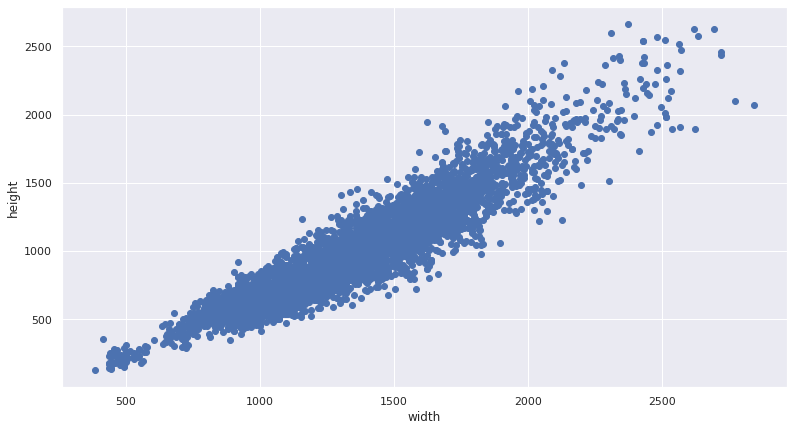

In [0]:
list_height=[]
list_width=[]

for img in train_data["image"]:
    img = Image.open(str(img))
    width, height = img.size
    list_width.append(width)
    list_height.append(height)

list_ratio=[]
for i in range(len(list_height)):
    list_ratio.append(list_height[i]/list_width[i])


print("Height : " , min(list_height), max(list_height), np.round(np.mean(list_height)))
print("Width : ",  np.round(min(list_width)),  np.round(max(list_width)), np.round(np.mean(list_width)))
print("Ratio : ",  np.round(min(list_ratio),2),  np.round(max(list_ratio),2), np.round(np.mean(list_ratio),2))


fig, ax = plt.subplots(figsize=(13,7))
ax.scatter(list_width, list_height)
ax.set_xlabel('width')
ax.set_ylabel('height')
plt.show()

Pas d'outliers particuliers, l'ensemble suit une distribution de taille relativement linéraire.

Distinguons à présent selon la classe des images : 

In [0]:
normal_width=[]
normal_height=[]
pneumonia_width=[]
pneumonia_height=[]

for img in train_data["image"]:
    image = Image.open(str(img))
    width, height = image.size
    if train_data[train_data["image"] == img]["label"].any() == 0:
        normal_width.append(width)
        normal_height.append(height)
    else:
        pneumonia_height.append(height)
        pneumonia_width.append(width)

normal_ratio=[]
pneumonia_ratio=[]

for i in range(len(normal_height)):
    normal_ratio.append(normal_height[i]/normal_width[i])
for i in range(len(pneumonia_height)):
    pneumonia_ratio.append(pneumonia_height[i]/pneumonia_width[i])

NORMAL
Height :  496 2663 1375.0
Width :  912 2844 1685.0
Ratio :  0.47 1.14 0.81
PNEUMONIA
Height :  127 2184 818.0
Width :  384 2772 1194.0
Ratio :  0.3 1.2 0.68


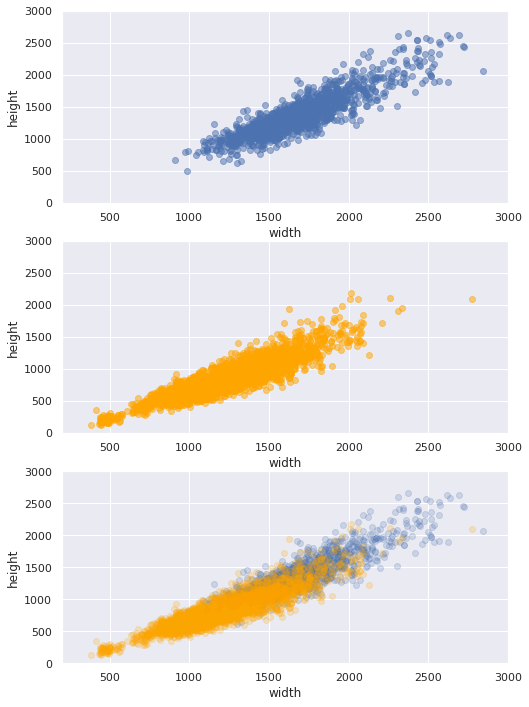

In [0]:
print('NORMAL')
print("Height : " , min(normal_height), max(normal_height), np.round(np.mean(normal_height)))
print("Width : ", min(normal_width), max(normal_width), np.round(np.mean(normal_width)))
print("Ratio : ",  np.round(min(normal_ratio),2),  np.round(max(normal_ratio),2), np.round(np.mean(normal_ratio),2))

print('PNEUMONIA')
print("Height : " , min(pneumonia_height), max(pneumonia_height), np.round(np.mean(pneumonia_height)))
print("Width : ", min(pneumonia_width), max(pneumonia_width), np.round(np.mean(pneumonia_width)))
print("Ratio : ",  np.round(min(pneumonia_ratio),2),  np.round(max(pneumonia_ratio),2), np.round(np.mean(pneumonia_ratio),2))


fig, ax = plt.subplots(3, 1, figsize=(8,12))
ax[0].scatter(normal_width, normal_height, alpha=0.5)
ax[1].scatter(pneumonia_width, pneumonia_height, alpha=0.5, color='orange')
ax[2].scatter(normal_width, normal_height, alpha=0.2)
ax[2].scatter(pneumonia_width, pneumonia_height, alpha=0.2, color='orange')

for i in range(3):
    ax[i].set_xlim([200, 3000])
    ax[i].set_ylim([0, 3000])
    ax[i].set_xlabel('width')
    ax[i].set_ylabel('height')

plt.show()


Les radio des individus sains sont en moyenne plus petites que celles des individus malades. Cependant, le ratio des dimensions dans les 2 classes semble etre assez proche.
Par conséquent, après compression pour avoir toutes les images de la même taille, nos algorithmes d'apprentissage devraient bien se baser sur les caractéristiques des images et non leur déformation.

Regardons de plus près les images :

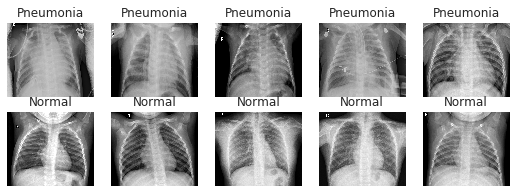

In [0]:
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

samples = pneumonia_samples + normal_samples

# Plot
f, ax = plt.subplots(2,5, figsize=(9,3))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

On pourrait penser à la vue de ces exemples que les pneumonies se manifestent par une augmentation du nombre de pixels blancs sur la radio dans la zone des poumons. Regardons la distribution de l'intensité moyenne, en enlevant les valeurs extrèmes (comme les 0 des zones noires) : 

100%|██████████| 3418/3418 [00:20<00:00, 165.33it/s]


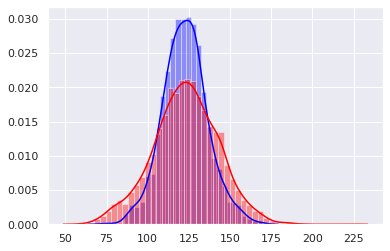

In [0]:
normal_brightness = []
pneumonia_brightness = []

for img in tqdm(train_normal):
    img = plt.imread(img)
    normal_brightness.append(stats.tmean(img))

for img in tqdm(train_pneumonia):
    img = plt.imread(img)
    pneumonia_brightness.append(stats.tmean(img))

sns.distplot(normal_brightness, color ='blue')
sns.distplot(pneumonia_brightness, color='red')


Les 2 distributions sont trop proches pour pouvoir distinguer les classes par ce genre d'analyses simples. 

# II. Présentation et entraînement des modèles 

Les images sont de dimensions différentes, on va donc les réduire à une taille raisonnable de 300x300 (une large majorité des images ont une taille plus grande). Entrainer des modèles de base, comme une random forest,  sur autant de features (90,000) paraît extrême, on va donc procéder à une ACP pour réduire la dimension de nos données.

### 1. ACP et random forest


On ouvre toutes les images avec 1 channel de couleur et on transforme chaque matrice en vecteur colonne

In [0]:
def transform(img, size):
    img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
    img = img.astype('float32') / 255
    img = cv2.resize(img, (size, size)) 
    img = np.reshape(img, (1,size*size))[0]
    return img

In [0]:
y = train_data['label']
X_train = train_data['image'].apply(lambda x: transform(x, 300))

In [0]:
X_train = X_train.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
X_train = np.vstack(X_train)
X_train.shape

(4684, 90000)

#### i. Compression des images

In [0]:
# On garde 90% de la variance
pca = PCA(n_components=0.9)

pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [0]:
X_train_pca.shape

(4684, 203)

On a divisé par plus de 400 la dimension de nos données en gardant 90% de leur variance. C'était à prévoir car les images sont bien standardisés.

#### ii. Random Forest

On entraîne une random forest sur l'ensemble de train réduit. On utilise une cross validation à 5 *folds*, et on va utiliser les score *Out-of-Bag* pour estimer le score de généralisation du modèle (On relance les blocs de code suivants plusieurs fois pour affiner GridSearchCV).

In [0]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [30],
    'min_samples_leaf': [6,7,8],
    'n_estimators': [200,300,400]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [0]:
grid_search.fit(X_train_pca, y)
grid_search.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.9min finished


{'bootstrap': True,
 'max_depth': 30,
 'min_samples_leaf': 6,
 'n_estimators': 300}

In [0]:
forest = RandomForestClassifier(bootstrap= True, max_depth=30, min_samples_leaf=6, n_estimators= 300, oob_score=True)
forest.fit(X_train_pca, y)
print('Score: ', forest.score(X_train_pca, y))
print('Out-of-Bag score: ', forest.oob_score_)

Score:  0.988471391972673
Out-of-Bag score:  0.8983774551665243


Les scores sont ici des scores d'*accuracy*, avec le second un score de généralisation. Même avec de la cross-validation, on a potentiellement de l'*overfitting*.
On va essayer d'obtenir une *accuracy* au moins supérieure dans les modèles suivants. 

### 2. ACP et réseau de neurones

On va essayer d'aller un peu plus loin avec les données projetés.

On reprends les données précédentes, et essayons d'entraîner un réseau de neuronnes simple dessus.
On ne va pas faire de cross-validation, trop gourmande en temps. On va donc créer un set de validation avec 12.5% du set de train restant, ce qui nous donne une répartion des images à 70% dans le set de train, 20% dans le set de test, et 10% dans le set de validation.

In [0]:
X_train, X_val, y_train_, y_val = train_test_split(X_train_pca, y, test_size=0.125, random_state=42)

In [0]:
epochs = 20
batch_size = 32

In [0]:
inputs = Input(shape=len(X_train[0]))

x = Dense(units=128, activation='relu')(inputs)
x = Dropout(rate=0.4)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=32, activation='relu')(x)
x = Dropout(rate=0.2)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model0 = Model(inputs=inputs, outputs=output)
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='ACP_res.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=8, mode='min')

In [0]:
model0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 203)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               26112     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0     

In [0]:
hist0 = model0.fit(X_train_pca, y, batch_size=batch_size, epochs=epochs, 
                   validation_data=(X_val, y_val), callbacks=[checkpoint, lr_reduce])

Train on 4684 samples, validate on 586 samples
Epoch 1/20
4684/4684 [==============================] - 1s 205us/sample - loss: 0.5210 - acc: 0.7837 - val_loss: 0.2101 - val_acc: 0.9147
Epoch 2/20
4684/4684 [==============================] - 0s 104us/sample - loss: 0.2632 - acc: 0.8962 - val_loss: 0.1582 - val_acc: 0.9266
Epoch 3/20
4576/4684 [============================>.] - ETA: 0s - loss: 0.2041 - acc: 0.9229
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
4684/4684 [==============================] - 1s 139us/sample - loss: 0.2047 - acc: 0.9223 - val_loss: 0.1165 - val_acc: 0.9539
Epoch 4/20
4684/4684 [==============================] - 0s 98us/sample - loss: 0.1735 - acc: 0.9332 - val_loss: 0.1105 - val_acc: 0.9539
Epoch 5/20
4480/4684 [===========================>..] - ETA: 0s - loss: 0.1695 - acc: 0.9371
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
4684/4684 [==============================] - 0s 102us/sample - loss

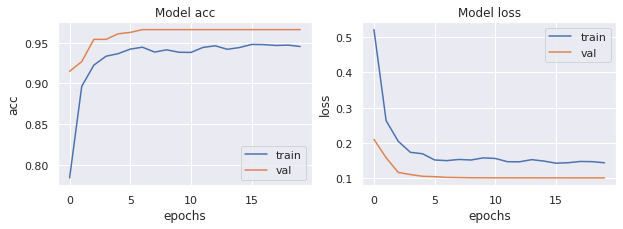

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist0.history[met])
    ax[i].plot(hist0.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

On obtient un excellent résultat avec 96% d'*accuracy*, et un modèle qui ne semble pas du tout overfiter

### 3. CNN

##### Préparatifs

On va maintenant tester des modèles de réseaux de neurones récurrents, très adaptés à l'analyse d'images. Ces derniers seront entraînés sur la base originale des images, qui seront reformatés en taille 300x300 lors du preprocessing.

In [0]:
train_normal, val_normal = train_test_split(train_normal, test_size=0.125, random_state=42)
train_pneumonia, val_pneumonia = train_test_split(train_pneumonia, test_size=0.125, random_state=42)

In [0]:
for img in val_normal:
    path= str(img).split('/')
    shutil.move(img, input_path + 'val/NORMAL/' + path[-1])

for img in val_pneumonia:
    path= str(img).split('/')
    shutil.move(img, input_path + 'val/PNEUMONIA/' + path[-1])

In [0]:
print("Train: ", len(list(train_normal)), len(list(train_pneumonia)))
print("Val: ", len(list(val_normal)), len(list(val_pneumonia)))
print("Test: ", len(list(test_normal)), len(list(test_pneumonia)))

Train:  938 2712
Val:  134 388
Test:  269 775


Chargons à présent les images. Les modules de tensorflow et la structure de nos dossier permet de charger les données très simplement.
La premiere fonction de chargement n'utilise pas de *data augmentation*, contrairement à la seconde.

In [0]:
def process_data(img_dims, batch_size):

    # Sans data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    
    train_gen = train_datagen.flow_from_directory(directory=input_path+'train', 
                                                  target_size=(img_dims, img_dims),
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=True)

    test_gen = test_datagen.flow_from_directory(directory=input_path+'test', 
                                                    target_size=(img_dims, img_dims),
                                                    batch_size=batch_size, 
                                                    class_mode='binary',
                                                    shuffle=True)
    
    val_gen = val_datagen.flow_from_directory(directory=input_path+'val', 
                                              target_size=(img_dims, img_dims),
                                              batch_size=batch_size, 
                                              class_mode='binary',
                                              shuffle=True)
    
    return train_gen, val_gen, test_gen

In [0]:
def process_data_augmented(img_dims, batch_size):

    # Avec data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range = 0.1, 
                                       horizontal_flip = True, rotation_range=10)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    
    train_gen = train_datagen.flow_from_directory(directory=input_path+'train', 
                                                  target_size=(img_dims, img_dims),
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=True)

    test_gen = test_datagen.flow_from_directory(directory=input_path+'test', 
                                                    target_size=(img_dims, img_dims),
                                                    batch_size=batch_size, 
                                                    class_mode='binary',
                                                    shuffle=True)
    
    val_gen = val_datagen.flow_from_directory(directory=input_path+'val', 
                                                    target_size=(img_dims, img_dims),
                                                    batch_size=batch_size, 
                                                    class_mode='binary',
                                                    shuffle=True)
    
    return train_gen, val_gen, test_gen

#### i. Transfer learning

Notre première idée a été d'utiliser un réseau de convolution pré-entrainé, ici le modèle VGG19. On a vu que les plupart des images ont une taille supérieure à 300x300, on réduit donc les images a cette taille.

In [0]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (300, 300, 3), classes = 2)

In [0]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [0]:
# On bloque les poids du réseau entraîné
vgg19.trainable=False

model1=Sequential()
model1.add(vgg19)

# On rajoute des couches finales
model1.add(Flatten())
model1.add(Dense(1024,activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(256,activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(64,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1,activation='softmax'))


model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='vgg19.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

In [0]:
img_dims = 300
epochs = 10
batch_size = 32

train_gen, val_gen, test_gen = process_data(img_dims, batch_size)

Found 4097 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


In [0]:
model1.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 9, 9, 512)         20024384  
_________________________________________________________________
flatten_9 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_54 (Dense)             (None, 1024)              42468352  
_________________________________________________________________
dropout_41 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 64)              

In [0]:
hist1 = model1.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=val_gen, 
           validation_steps=val_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/10
128/128 [==============================] - 69s 535ms/step - loss: 4.1031 - acc: 0.7304 - val_loss: 4.1035 - val_acc: 0.7309
Epoch 2/10
128/128 [==============================] - 66s 517ms/step - loss: 4.1293 - acc: 0.7287 - val_loss: 4.1035 - val_acc: 0.7309
Epoch 3/10
 18/128 [===>..........................] - ETA: 49s - loss: 4.1035 - acc: 0.7309
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
128/128 [==============================] - 62s 483ms/step - loss: 4.2295 - acc: 0.7296 - val_loss: 4.1035 - val_acc: 0.7309
Epoch 4/10
128/128 [==============================] - 61s 476ms/step - loss: 4.1068 - acc: 0.7301 - val_loss: 4.1035 - val_acc: 0.7309
Epoch 5/10
 18/128 [===>..........................] - ETA: 52s - loss: 4.1035 - acc: 0.7309
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
128/128 [==============================] - 61s 480ms/step - loss: 4.2257 - acc: 0.7299 - val_loss: 4.1035 - val_acc: 0.7309
Epo

On a des scores très mauvais meme sur le set d'entrainement, ce réseau ne fait pas mieux qu'un classifieur naïf (74% d'*accuracy*)

#### ii. Depthwise Convolution

On décide donc d'entraîner un réseau à partir de 0.
Un des modèles qui semble obtenir des bons scores est un modèle de CNN basé sur de la depthwise convolution (explicitée dans le rapport) qui a l'avantage de donner des bons résultats avec un petit réseau, qui optimise la réduction de la dimension des images, avec moins de paramètres sans perte d'efficacité.

In [0]:
img_dims = 300
epochs = 12
batch_size = 32

train_gen, val_gen, test_gen = process_data(img_dims, batch_size)

Found 4097 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


In [0]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Sixth conv block
x = SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=4096, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=2048, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.4)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.2)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model2 = Model(inputs=inputs, outputs=output)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='depthwise.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, mode='min')

In [0]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 150, 150, 32)      688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 150, 150, 32)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128   

In [0]:
hist2 = model2.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=val_gen, 
           validation_steps=val_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce, early_stop])

Epoch 1/12
114/114 [==============================] - 122s 1s/step - loss: 0.5118 - acc: 0.7460 - val_loss: 0.8012 - val_acc: 0.7383
Epoch 2/12
114/114 [==============================] - 117s 1s/step - loss: 0.3386 - acc: 0.8720 - val_loss: 1.8336 - val_acc: 0.7383
Epoch 3/12
114/114 [==============================] - 116s 1s/step - loss: 0.2771 - acc: 0.8961 - val_loss: 1.5874 - val_acc: 0.7383
Epoch 4/12
114/114 [==============================] - 117s 1s/step - loss: 0.2540 - acc: 0.9107 - val_loss: 1.9720 - val_acc: 0.7383
Epoch 5/12
114/114 [==============================] - 117s 1s/step - loss: 0.2527 - acc: 0.9035 - val_loss: 1.0504 - val_acc: 0.7383
Epoch 6/12
 16/114 [===>..........................] - ETA: 48s - loss: 0.3515 - acc: 0.8203
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
114/114 [==============================] - 118s 1s/step - loss: 0.2225 - acc: 0.9218 - val_loss: 0.3515 - val_acc: 0.8203
Epoch 7/12
114/114 [=====================

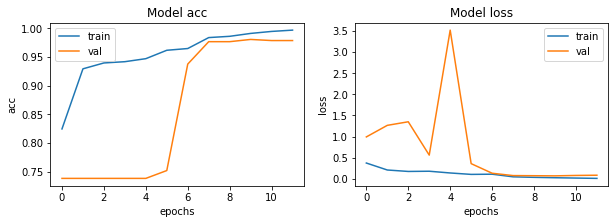

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist2.history[met])
    ax[i].plot(hist2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

On atteint des scores significativement supérieurs au VGG19. Néamoins, le score maximum de ce modèle est atteint au bout de 7 époques, avec un léger *overfit* passé ce point. On va donc réentraîner ce réseau avec de l'augmentation de données

In [0]:
model3 = Model(inputs=inputs, outputs=output)
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
train_gen, val_gen, test_gen = process_data_augmented(img_dims, batch_size)
epochs = 20

hist3 = model3.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=val_gen, 
           validation_steps=val_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Found 4097 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 587 images belonging to 2 classes.
Epoch 1/20
128/128 [==============================] - 145s 1s/step - loss: 0.4818 - acc: 0.7567 - val_loss: 0.6384 - val_acc: 0.7292
Epoch 2/20
128/128 [==============================] - 135s 1s/step - loss: 0.3001 - acc: 0.8900 - val_loss: 0.7677 - val_acc: 0.7292
Epoch 3/20
128/128 [==============================] - 135s 1s/step - loss: 0.2517 - acc: 0.9075 - val_loss: 0.7017 - val_acc: 0.7292
Epoch 4/20
128/128 [==============================] - 134s 1s/step - loss: 0.2621 - acc: 0.9009 - val_loss: 2.2885 - val_acc: 0.7292
Epoch 5/20
128/128 [==============================] - 133s 1s/step - loss: 0.2260 - acc: 0.9223 - val_loss: 0.9148 - val_acc: 0.7292
Epoch 6/20
 18/128 [===>..........................] - ETA: 59s - loss: 0.3728 - acc: 0.9115 
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
128/128 [============================

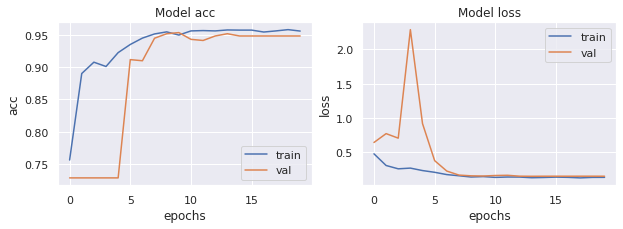

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist3.history[met])
    ax[i].plot(hist3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

On remarque de légers progrès par rapport à la version sans data augmentation, avec une *accuracy* maximale de 95% sur le set de validation.

# III . Résultats finaux et analyse

### Comparaison des modèles

Pour la comparaison avec les méthodes d'ACP, il faut d'abord projeter les données de test

In [0]:
test_data = []
test_labels = []

size = 300
for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = cv2.imread(input_path + 'test' + cond+str(img), cv2.IMREAD_GRAYSCALE)
        img = img.astype('float32') / 255
        img = cv2.resize(img, (size, size)) 
        img = np.reshape(img, (1,size*size))[0]
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)

In [0]:
test_data = pca.transform(test_data)

In [0]:
test_data.shape

(1172, 203)

#### i. ACP et random forest

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds= forest.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Specificity: {}%'.format(specificity))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

CONFUSION MATRIX ------------------
[[215 102]
 [  6 849]]

TEST METRICS ----------------------
Accuracy: 90.78498293515358%
Precision: 89.27444794952682%
Specificity: 67.82334384858044%
Recall: 99.29824561403508%
F1-score: 94.01993355481727


La random forest a un excellent *recall*, presque tous invidus malades ont été détectés. Cependant on a beaucoup de faux positifs avec une spécificité de seulement 68%.

#### ii. ACP et réseau de neurones

In [0]:
model0.load_weights(filepath='ACP_res.hdf5')
preds = model0.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Specificity: {}%'.format(specificity))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

CONFUSION MATRIX ------------------
[[284  33]
 [ 22 833]]

TEST METRICS ----------------------
Accuracy: 95.30716723549489%
Precision: 96.18937644341801%
Specificity: 89.58990536277602%
Recall: 97.42690058479532%
F1-score: 96.80418361417779


On a d'excellents scores pour ce modèle, bien que le *recall* soit plus faible, bien qu'il reste à 97%. Le taux de faux positifs a drastiquement baissé puisqu'on a une spécificité de presque 90%.

#### iii. CNN

In [0]:
# Creation des labels pour le test

test_data_cnn = []
test_labels_cnn = []
img_dims=300

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = plt.imread(input_path+'test'+cond+img)
        img = cv2.resize(img, (img_dims, img_dims))
        if len(img.shape) == 2:
          img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
        test_data_cnn.append(img)
        test_labels_cnn.append(label)
        
test_data_cnn = np.array(test_data_cnn)
test_labels_cnn = np.array(test_labels_cnn)

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix

model3.load_weights(filepath='depthwise.hdf5')
preds = model3.predict(test_data)

acc = accuracy_score(test_labels_cnn, np.round(preds))*100
cm = confusion_matrix(test_labels_cnn, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

CONFUSION MATRIX ------------------
[[292  25]
 [ 24 831]]

TEST METRICS ----------------------
Accuracy: 95.81911262798634%
Precision: 97.07943925233646%
Recall: 97.19298245614036%
F1-score: 97.13617767387493


In [0]:
print('Specificity: ', 292/(292+25)*100)

Specificity:  92.11356466876973


On a avec ce modèle des résultats très proches du modèle ACP + réseau de neurones. On a uniquement 2 faux négatifs de plus, et 92% de spécificité. Des 3 modèles c'est ce dernier qui est le plus équilibré.
On pourra discuter dans le rapport des métriques les plus pertinentes pour trancher éventuellement en faveur d'un des modèles.

### Analyse du CNN

On peut regarder les *feature maps* des couches du réseau de neurones. On ne regarde que les 4 premières, passé ce point les couches sont entrainés sur des images très compressés dont il est dur de tirer une interprétation.

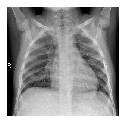

In [0]:
ixs = [2, 6, 10, 14]
outputs = [model3.layers[i].output for i in ixs]
model = Model(inputs=model3.inputs, outputs=outputs)
feature_maps = model.predict(np.array([(np.array(test_gen[1][0][0]))]))

# Image originale
fig, ax = plt.subplots(figsize=(2,2))
img = np.array(test_gen[1][0][0]) 
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.set_aspect('auto')

Bloc de convolution  1


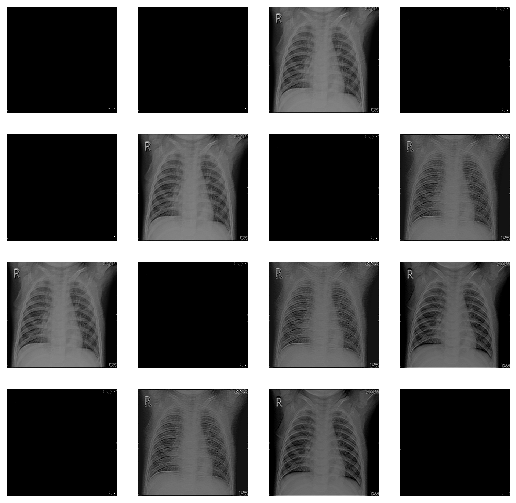

Bloc de convolution  2


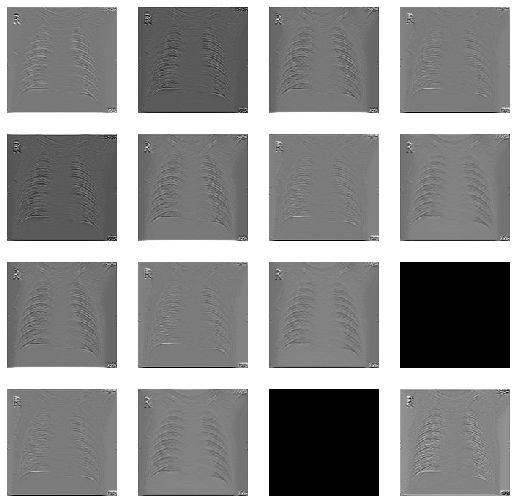

Bloc de convolution  3


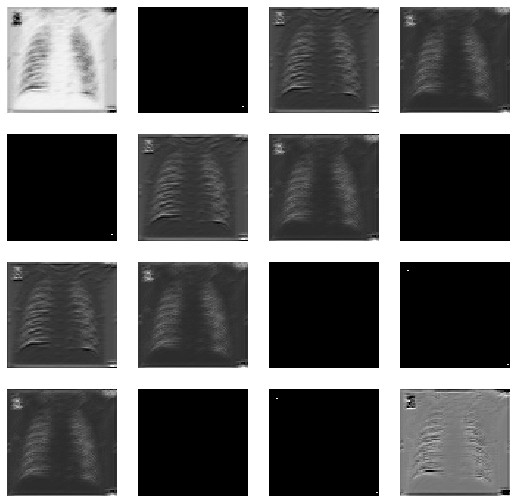

Bloc de convolution  4


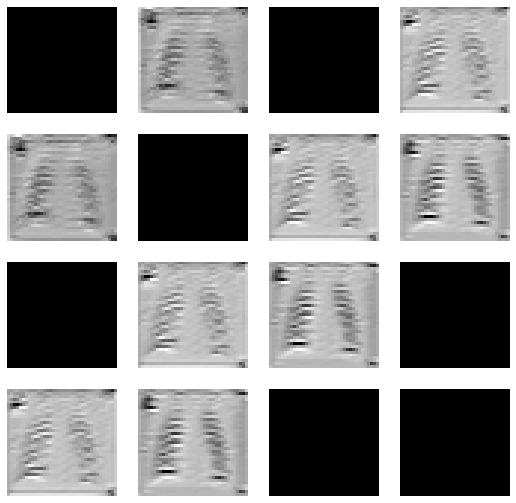

In [0]:
for c, fmap in enumerate(feature_maps):
  fig, ax = plt.subplots(4, 4, figsize=(9,9))
  print("==================================")
  print("Bloc de convolution ", c+1)

  for i in range(4):
      for j in range(4):
              # specify subplot and turn of axis
              img = fmap[0, :, :, i+j]
              ax[i, j].imshow(img, cmap='gray')
              ax[i, j].axis('off')
              ax[i, j].set_aspect('auto')
  plt.show()


Les couches contiennent de nombreux filtre constants, en particulier celles du premier bloc.
Mais à partir du 3ème bloc de convolution, on remarque que le réseau réussi à identifier la région des poumons, qui passe en surbrillance. Le CNN a donc bien determiné un motif, uniquement dans les poumons, qui permet de distinguer les 2 classes.